*   Correctness of BPTT.
*   Convergence of the model training.
*   Demonstrate vanishing/exploding gradients.


In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
!pwd
os.chdir('gdrive/My Drive/research/Datasets/Amazon_UCSD')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/research/Datasets/Amazon_UCSD
assignment2		    glove_model_3.pt
char_rnn_model_0_1000.pkl   hhh.png
char_rnn_model_3_10000.pkl  json_to_csv.py
char_rnn_model_3_9000.pkl   reviews_Cell_Phones_and_Accessories_5.csv
glove.6B.300d.txt	    small.csv
glove_model_10.pt	    test_small.csv
glove_model_1.pt	    train_small.csv
glove_model_20.pt	    valid_small.csv
glove_model_24.pt


## Section 1 Vanilla char-RNN
Implement, train, and evaluate a simple RNN where the input are sequences of characters from sentences. This RNN can then be used to generate sentences char-by-char.

NO Pytorch here but raw numpy codes. The idea is to have you go deeper into the model.

You will explore the explosion and vanishing gradient issues in this example and have a deeper understanding of RNN before moving to fancier recurrent networks such as LSTM (bidirectinal possibly with attention) in the following sections.

The equation numbers are referring to the deep learning book (online version).
Chap10 https://www.deeplearningbook.org/contents/rnn.html

### First import necessary packages and define global variables



In [0]:
"""
    Codes borrowed from Karpathy:
    https://gist.github.com/karpathy/d4dee566867f8291f086
"""
import numpy as np
import pandas as pd
import pickle


char_to_ix = {}
ix_to_char = {}
review_in_ix = None # training corpus
valid_review_in_ix = None # validation corpus
test_review_in_ix = None # test corpus
texts = None
avg_len = None


# model and training
hidden_size = 128
learning_rate = 1e-4
input_size = None   # the number of unique characters in the alphabet
output_size = None  # same as input_size


# model parameters: the naming follows the "Deep Learning" book RNN notation.
U = None    # mapping from x to h
W = None    # mapping from previous h to current h
b = None    # bias in mapping from x to h
V = None    # mapping from h to o
c = None    # bias in mapping from h to o

seq_length = 25


### Then define utility functions for saving, loading, and initializing models.



In [0]:
def save_model(epoch_id, iteration_id, state_dict):
    """
    Make sure you have created a folder called "assignment2" under "Amazon_UCSD"
    """
    with open(f'assignment2/char_rnn_model_{epoch_id}_{iteration_id}.pkl', 'wb') as out_f:
        pickle.dump(state_dict, out_f)


def load_model(epoch_id, iteration_id):
    global U, V, W, b, c
    global mU, mV, mW, mb, mc
    global epoches, n
    global smooth_loss

    print(f'Loading pre-trained model from epoch {epoch_id}, iteration {iteration_id}')
    with open(f'assignment2/char_rnn_model_{epoch_id}_{iteration_id}.pkl', 'rb') as in_f:
        params = pickle.load(in_f)
    
        U = params['U']
        V = params['V']
        W = params['W']
        b = params['b']
        c = params['c']

        mU = params['mU']
        mV = params['mV']
        mW = params['mW']
        mb = params['mb']
        mc = params['mc']

        epoches = epoch_id
        n = iteration_id

        smooth_loss = params['smooth_loss']


def init_model():
    """
    Randomly initialize all model parameters, all Adam optimizer variables,
    the smooth_loss, the epoch and iteration numbers.
    """
    global U, V, W, b, c
    global mU, mV, mW, mb, mc
    global epoches, n
    global smooth_loss

    W = np.random.randn(hidden_size, hidden_size) * 0.01  # mapping from h to h
    U = np.random.randn(hidden_size, input_size) * 0.01  # mapping from x to h
    V = np.random.randn(output_size, hidden_size) * 0.01  # mapping from h to o
    b = np.zeros((hidden_size, 1))  # bias term in the hidden unit
    c = np.zeros((output_size, 1))  # bias term in the output unit

    # sentence counter and batch counter
    epoches, n = 0, 0
    mU, mV, mW = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    mb, mc = np.zeros_like(b), np.zeros_like(c)
    smooth_loss = -np.log(1.0/output_size) # * avg_len

### Functions for handling text data



In [0]:
def read_reviews(path):
    """
    Read a csv file of Amazon reviews and put the reviews in texts.
    :param path: pointing to the csv file.
    """
    print(path)
    df = pd.read_csv(path)
    texts = []
    for r in range(df.shape[0]):
        try:
            texts.append(df.iloc[r, 0])
        except Exception as inst:
            break
    print('{} reviews loaded.'.format(df.shape[0]))
    return texts


def reviews_to_ix(texts):
    """
    Build indices of the characters (the alphabet)
    and turn the sentences into sequences of char indices.
    """

    global char_to_ix, ix_to_char, review_in_ix, avg_len
    global input_size, output_size

    chars = set()
    for review in texts:
        try:
            chars.update(set(review))
        except:
            pass
          
    chars=sorted(chars)
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    char_to_ix['eos'] = len(char_to_ix)
    ix_to_char = {i: ch for i, ch in enumerate(chars)}
    ix_to_char[char_to_ix['eos']] = 'eos'

    # turn reviews into sequence of character indices.
    review_in_ix = []
    for review in texts:
        try:
            review_in_ix.append([char_to_ix[c] for c in review])
        except:
            pass

    input_size = len(char_to_ix)
    output_size = input_size    # the output space is the same as the input space

    print(f'{len(review_in_ix)} reviews; '
          f'{len(char_to_ix)} unique chars (input_size); '
          f'{sum([len(s) for s in review_in_ix])} chars in total')
    avg_len = np.mean([len(s) for s in review_in_ix])


def more_review_to_ix(more_texts):
    """
    Assume that the training reviews have been indexed and the char_to_ix is built,
    now index additional reviews (for validation and testing).
    """
    global char_to_ix

    # turn reviews into sequence of character indices.
    more_review_in_ix = []
    for review in more_texts:
        try:
            more_review_in_ix.append([char_to_ix[c] for c in review])
        except:
            pass
    return more_review_in_ix

### Define the RNN loss function.



In [0]:
def lossFunc(inputs, targets, hprev=None, monitor_gradient=False):
    """
    Define the loss function and implement the BPTT algorithm.
    Note that this is not the built-in PyTorch loss.

    :param inputs: an array of integers, representing char indices in a review.
    :param targets: an array of integers, which is the shift of inputs to the right by one time step.
    :param hprev: initial hidden states. If None, start from all zeros.
    :param monitor_gradient: if set to True, then return the norm of the gradient with respect to h at all time steps as an array.

    :return: the loss, the gradients on model parameters, and the last hidden state
    """
    # RNN parameters
    global U, V, W, b, c
    h_gradient_norms = []

    assert len(inputs) == len(targets), f'inputs and targets have different lengths,\
        {len(inputs)} != {len(targets)}'

    # implement the BPTT algorithm

    x, h, o, p, = {}, {}, {}, {}

    if hprev is None:
        hprev=np.zeros((hidden_size,1))


    h[-1] = np.copy(hprev)

    loss=0

    # forward pass
    for t in range(len(inputs)):
        #x[t] = np.zeros((input_size, 1))
        #x[t][inputs[t]] = 1
        #h[t] = np.tanh(np.dot(U, x[t]) + np.dot(W, h[t - 1]) + b)
        #take advantage of one hot input vector
        h[t] = np.tanh(U[:,inputs[t]].reshape(-1,1) + np.dot(W, h[t - 1]) + b)
        o[t] = np.dot(V, h[t]) + c
        p[t] = np.exp(o[t]) / np.sum(np.exp(o[t]))
        loss += -np.log(p[t][targets[t], 0])

    # backward pass

    dW, dU, dV = np.zeros_like(W), np.zeros_like(U), np.zeros_like(V)
    db, dc = np.zeros_like(b), np.zeros_like(c)
    dhtnext = np.zeros_like(h[0])
    for t in reversed(range(len(inputs))):
        dydo = np.copy(p[t])
        dydo[targets[t]] -= 1
        dodV=h[t].T
        dV += np.dot(dydo, dodV)
        dc += dydo

        dh = np.dot(V.T,dydo) + dhtnext

        if monitor_gradient:
            h_gradient_norms.append(np.linalg.norm(dh))

        diag_dh = (1 - h[t] * h[t]) * dh
        db += diag_dh
        #dU += np.dot(diag_dh, x[t].T)
        #take advantage of one hot input vector
        dU[:,inputs[t]] += diag_dh.reshape(-1)
        dW += np.dot(diag_dh, h[t - 1].T)
        dhtnext = np.dot(W.T, diag_dh)
        
    for dparam in [dU, dW, dV, db, dc]:
      np.clip(dparam, -5, 5, out=dparam)




    return loss, dU, dV, dW, db, dc, h[len(inputs) - 1], h_gradient_norms

def sample(h, seed_idx, n):
    """
    Sample a sentence of length n from the current model.
    Use teacher forcing so that a predicted char will be fed into the
    RNN as input to the next step.

    :param h: memmory state
    :param seed_idx: seed letter for the first time step
    :param n: length of the sentence
    :return: the indices of the generated chars.
    """
    global U, V, W, b, c

    x = np.zeros((input_size, 1))
    x[seed_idx] = 1
    ixes = []

    for t in range(n):
        ## Your codes start here (code block 2)
        h = np.tanh(np.dot(U, x) + np.dot(W, h) + b)
        y = np.dot(V, h) + c
        Z=np.sum(np.exp(y))
        p = np.exp(y) /Z
        #ix = np.argmax(p)
        ix = np.random.choice(range(input_size), p=p.ravel())
        x = np.zeros((input_size, 1))
        x[ix] = 1
        ixes.append(ix)
    
        ## Your codes end here
    return ixes


def run_model(corpus_in_ix):
    """
    Given any set of reviews, find the loss on this corpus.

    You need to prepare the input and target for each sequence here.

    :param corpus_in_ix: input reviews that have been turned into char indices.
    return: the average loss.
    """
    global U, V, W, b, c
    total_loss = 0  # the sum of losses over all positions
    total_targets = 0  # the total number of positions

    for n in range(len(corpus_in_ix)):

        # calculate total_loss and total_targets
        review = review_in_ix[n]
        review.append(char_to_ix['eos'])
        index = 0
        
        hprev = np.zeros((hidden_size, 1))
        while (index + seq_length + 1 <= len(review)):
            inputs = review[index:index + seq_length]
            targets = review[index + 1:index + seq_length + 1]

            # forward pass
            for t in range(len(inputs)):
                x= np.zeros((input_size, 1))
                x[inputs[t]] = 1
                hprev = np.tanh(np.dot(U, x) + np.dot(W, hprev) + b)
                y = np.dot(V, hprev) + c
                p = np.exp(y) / np.sum(np.exp(y))
                total_loss += -np.log(p[targets[t], 0])
                total_targets+=1

            index+=1


    return total_loss / total_targets


def train(num_epoches):
    """
    SGD with Adam training.
    For Adam training, refer to lines 82-83 and 108-109 of Karpathy's codes:
        https://gist.github.com/karpathy/d4dee566867f8291f086

    Each iteration of the SGD takes one review, foward, backprop, and lastly update the parameters.

    The model parameters, the Adam variables, the epoches, n, and smooth_loss
    should have been initialized somewhere outside train() using init_model or load_model.

    :param num_epoches: how many epoches to train the model.
                        if continue training, add these epoches to the pre-trained epoches
    """
    # DO NOT change these global variable declarations.
    global U, V, W, b, c
    global mU, mV, mW, mb, mc
    global epoches, n
    global smooth_loss
    global review_in_ix, valid_review_in_ix, test_review_in_ix
  

    # the SGD loop
    for i in range(num_epoches):
        # go to the next epoch when the last one finishes
        if n == len(review_in_ix) or n == 0:
            n = 0
            epoches += 1
            
        print(epoches)



        # prepare a pair of input-target sequences for training.
        # Take care of the eos special symbol that signal the end of sentences.

        # forward pass: prepare the initial hidden state, and then call lossFunc
        # to find the loss and the gradients on this particular training pair.

        while(n<len(review_in_ix)):

            review=review_in_ix[n]
            review.append(char_to_ix['eos'])
            index=0
            hprev = None
            while(index + seq_length + 1<=len(review)):
                inputs = review[index:index + seq_length]
                targets = review[index + 1:index + seq_length + 1]
                loss, dU, dV, dW, db, dc,hprev,h_gradient_norms = lossFunc(inputs, targets, hprev,True)


                # normalize the current loss and accurate the normalized loss
                loss /= len(inputs)
                smooth_loss = smooth_loss * 0.999 + loss * 0.001

                # Gradient descent with Adam updates
                for param, dparam, mem in zip([U, V, W, b, c],
                                              [dU, dV, dW, db, dc],
                                              [mU, mV, mW, mb, mc]):
                    mem += dparam * dparam  # element-wise squares of the parameters
                    param -= learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

                index+=1

            # every 2000 training pairs.
            n += 1
            if n % 100 == 0:
                # sample a sentence from the current model
                ixes = sample(np.zeros_like(hprev), inputs[0], 200)
                ss=''.join([ix_to_char[ix] for ix in ixes])
                print(f'-----{ss}-----')
                # find validation and test losses.
                valid_loss = run_model(valid_review_in_ix[:30])
                test_loss = run_model(test_review_in_ix[:30])
                #print(smooth_loss)
                print(f'iter {n}, training loss: {smooth_loss}, validation loss: {valid_loss}, test loss: {test_loss}')
                #print(h_gradient_norms)
                
            if n%1000==0:
                # save the model to file for later continuing training
                save_model(epoches, n,
                             {'U': U, 'V': V, 'W': W, 'b': b, 'c': c, 'mU': mU, 'mV': mV, 'mW': mW, 'mb': mb, 'mc': mc,
                              'smooth_loss': smooth_loss})


### Main codes for model training



In [0]:
if __name__ == '__main__':

    # decide if we want to load a pre-trained model to continue the training.
    # this is a useful feature when you want to stop training in the middle.
    used_pretrained = True

    tr_reviews = read_reviews('train_small.csv')
    reviews_to_ix(tr_reviews)
    
    test_reviews = read_reviews('test_small.csv')
    test_review_in_ix = more_review_to_ix(test_reviews)

    valid_reviews = read_reviews('valid_small.csv')
    valid_review_in_ix = more_review_to_ix(valid_reviews)
    
    # load a pre-trained model
    # you can decide from which epoch and iteration to continue training.
    if used_pretrained:
        pre_trained_epoches = 4
        pre_trained_iterations = 4000
        load_model(pre_trained_epoches, pre_trained_iterations)
    else:
        # otherwise, randomly initialized the model
        init_model()

    # start or continue training
    num_epoches = 4
    train(num_epoches)

    


train_small.csv
16000 reviews loaded.
15989 reviews; 94 unique chars (input_size); 9418362 chars in total
test_small.csv
5000 reviews loaded.
valid_small.csv
4000 reviews loaded.
Loading pre-trained model from epoch 4, iteration 4000
4
-----phitheack. I'm a going when heavainal wonding the varlopmberrains small:1 so this erites play but always same to using how.  The tial proase  heariragily letty a store sout to consue heple of the mont-----
iter 4100, training loss: 1.5995448749539587, validation loss: 1.6145369935880092, test loss: 1.6157026015415652
-----ool nexime the everghiston gloks and about it to my Moborm if you wats times is in yet at to buttrabilizonos' can do eols extra) the replace I disly more broking. The skly osed if unngt?  The Black sh-----
iter 4200, training loss: 1.7657251023495384, validation loss: 1.6159882609442178, test loss: 1.6169695355918816
-----Dristen song picksever that where the phone voice to when my phone. the screen with the singitsalling enjoy to-

train_small.csv
16000 reviews loaded.
15989 reviews; 94 unique chars (input_size); 9418362 chars in total
Loading pre-trained model from epoch 1, iteration 3000


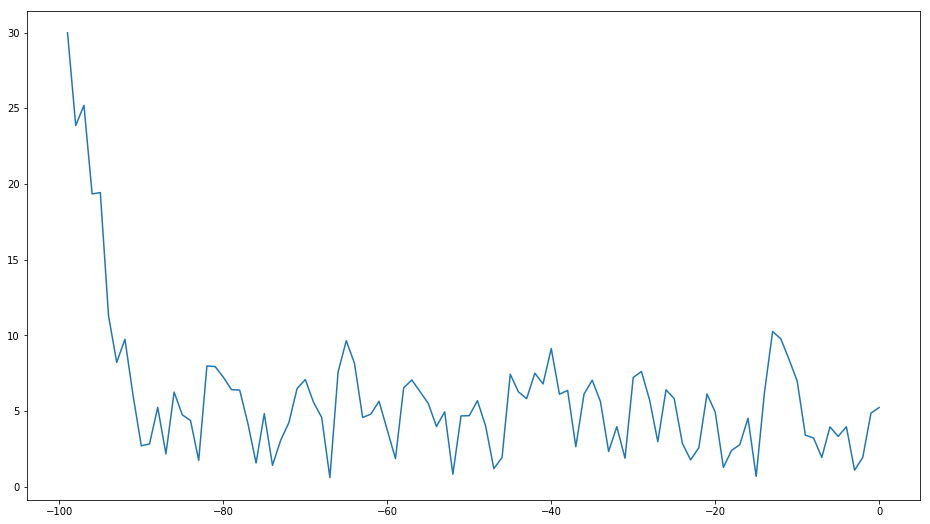

In [0]:
# after training, call lossFunc() and plot the gradients calculated
# on an arbitrary review to see if the gradients over time vanish or explode
# The plot should be display in this Jupyter notebook.
## Your codes start here (code block 5)
# calculate total_loss and total_targets
    
    
import random
import matplotlib.pyplot as plt
index=0
tr_reviews = read_reviews('train_small.csv')
reviews_to_ix(tr_reviews)
review=review_in_ix[random.randint(0,len(review_in_ix)-1)]
while (4*seq_length + 1>len(review)):
  review=review_in_ix[random.randint(0,len(review_in_ix)-1)]
  
pre_trained_epoches = 1
pre_trained_iterations = 3000
load_model(pre_trained_epoches, pre_trained_iterations)
#init_model()

hprev = np.zeros((hidden_size, 1))

inputs = review[index:index + 4*seq_length]
targets = review[index + 1:index + 4*seq_length + 1]
loss, dU, dV, dW, db, dc, hprev, h_gradient_norms = lossFunc(inputs, targets, hprev,True)

plt.figure(figsize=(16, 9))
time=-1*np.arange(4*seq_length)
plt.plot(time,h_gradient_norms)
plt.show()



## Your codes end here